##Melanoma Classifier Kernel
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

The dataset is taken from the ISIC (International Skin Image Collaboration) Archive. It consists of 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The pictures have all been resized to low resolution (224x224x3) RGB. The task of this kernel is to create a model, which can classify a mole visually into benign and malignant. 


**Step 1 : Importing Essential Libraries**<br>
**Step 2: Loading pictures and making Dictionary of images and labels** <br>
**Step 3: Categorical Labels** <br>
**Step 4: Normalization** <br>
**Step 5: Model Building**<br>
**Step 6: ResNet50** <br>

# Step 1 : importing Essential Libraries

In [5]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns

from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools


from tensorflow import keras

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import batch_normalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import backend as K 


# Step 2 : Loading pictures and making Dictionary of images and labels
In this step I load in the pictures and turn them into numpy arrays using their RGB values. As the pictures have already been resized to 224x224, there's no need to resize them. As the pictures do not have any labels, these need to be created. Finally, the pictures are added together to a big training set and shuffeled.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from google.colab import drive
drive.flush_and_unmount()

In [6]:
folder_benign_train = '/content/drive/MyDrive/MelDataset/train/benign'
folder_malignant_train = '/content/drive/MyDrive/MelDataset/train/malignant'

folder_benign_test = '/content/drive/MyDrive/MelDataset/test/benign'
folder_malignant_test = '/content/drive/MyDrive/MelDataset/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


In [7]:
# Merge data 
X_train = np.concatenate((X_benign,X_malignant),axis=0)
y_train = np.concatenate((y_benign, y_malignant),axis=0)
X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

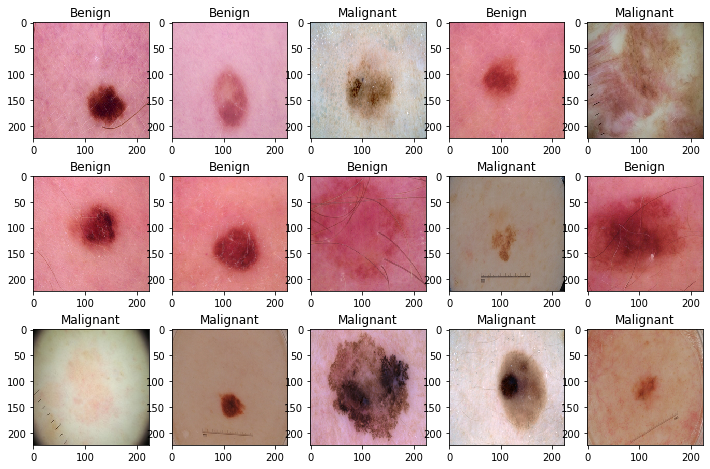

In [8]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Step 3: Categorical Labels
Turn labels into one hot encoding

In [9]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Step 4 : Normalization
Normalize all Values of the pictures by dividing all the RGB values by 255

In [10]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

# Step 5: Model Build



In [11]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)



# Step 6: ResNet50
The Resnet50 is tried

Epoch 1/50
33/33 - 89s - loss: 0.8893 - accuracy: 0.6335 - val_loss: 0.7148 - val_accuracy: 0.5360
Epoch 2/50
33/33 - 43s - loss: 0.5122 - accuracy: 0.7487 - val_loss: 0.7392 - val_accuracy: 0.5360
Epoch 3/50
33/33 - 43s - loss: 0.4320 - accuracy: 0.7952 - val_loss: 0.7815 - val_accuracy: 0.5360
Epoch 4/50
33/33 - 43s - loss: 0.3918 - accuracy: 0.8160 - val_loss: 0.7834 - val_accuracy: 0.5360
Epoch 5/50
33/33 - 43s - loss: 0.3820 - accuracy: 0.8189 - val_loss: 0.7935 - val_accuracy: 0.5360
Epoch 6/50
33/33 - 43s - loss: 0.3579 - accuracy: 0.8340 - val_loss: 0.9182 - val_accuracy: 0.5360

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 7/50
33/33 - 43s - loss: 0.3640 - accuracy: 0.8288 - val_loss: 0.9444 - val_accuracy: 0.5360
Epoch 8/50
33/33 - 43s - loss: 0.3233 - accuracy: 0.8549 - val_loss: 0.9810 - val_accuracy: 0.5360
Epoch 9/50
33/33 - 43s - loss: 0.3353 - accuracy: 0.8483 - val_loss: 0.8656 - val_accuracy: 0.5549
Epoch 10/50
33/33 - 43s - lo

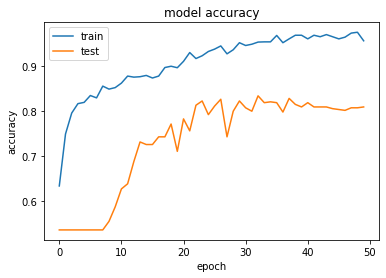

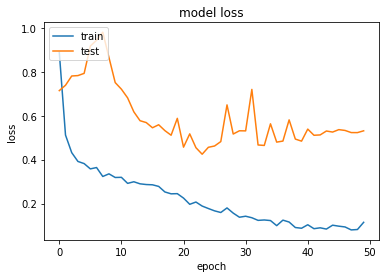

In [12]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [13]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )


KeyboardInterrupt: ignored

In [14]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

0.8090909090909091


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk
